# Progetto ML:  Text Classification


Il seguente progetto, realizzato e presentato relativamente al corso di ML 2021/2022, presenta come fine ultimo l’applicazione di metodologie di apprendimento supervisionato al task di Text Classification. 

In [1]:
import pandas as pd
import numpy as np
import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.preprocessing import LabelEncoder
from collections import defaultdict
from nltk.corpus import wordnet as wn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import model_selection, naive_bayes, svm
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix
import seaborn as sn
import matplotlib.pyplot as plt
from sklearn import metrics

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/fabiofontana/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/fabiofontana/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/fabiofontana/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/fabiofontana/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Importazione dataset da file .txt sottoforma di Datafram grazie alla libreria Pandas.
Primo pre-processing in cui vengono aggiunte le intestazioni delle colonne (label, question) e viene formattata la struttura dal dataframe in un formato utile per poterla utilizzare agevolmente. 
Si esegue poi una prima fase di check per la presenza di valori nulli/mancanti, dopodichè si esegue il lowercasing del testo, seguito da tokenizzazione e POS tagging. 

In [2]:
Corpus = pd.read_csv("training_set.txt", sep = "delimiter", engine = "python", encoding='latin-1', header = None)

#vado a separare le frasi dato un separatore in questo caso lo spazio
#considero 1 come numero di volte che devo splittare, expand=true mi fa ritornare un dataframe
Corpus = Corpus[0].str.split('\t', 1, expand=True)

#assegno le etichette alle colonne del dataframe
Corpus.columns=["label", "question"]

#sostituisco |t con lo spazio tra la frase e l'autore
Corpus['question'] = Corpus['question'].str.replace('\t',' ')

#dropna rimuoive valori nulli
Corpus['question'].dropna(inplace=True)

#lowercasing
Corpus['question'] = [entry.lower() for entry in Corpus['question']]

#word tokenizing separa ogni elemento della frase nella colonna question
Corpus['question']= [word_tokenize(entry) for entry in Corpus['question']]

#POS tagging con i valori dal dizionario wordnet
tag_map = defaultdict(lambda : wn.NOUN)
tag_map['J'] = wn.ADJ
tag_map['V'] = wn.VERB
tag_map['R'] = wn.ADV


In [3]:
Corpus

,label,question
0,HISTORY,"[``, this, state, 's, been, ``, '', on, my, mi..."
1,LITERATURE,"[western, novelist, francis, harte, 's, middle..."
2,MUSIC,"[``, this, ``, '', billy, the, kid, '', '', co..."
3,MUSIC,"[noted, with, a, dot, on, the, score, ,, it, '..."
4,SCIENCE,"[if, the, solar, system, 's, 9, planets, were,..."
...,...,...
9495,GEOGRAPHY,"[this, sea, provides, most, of, turkey, 's, no..."
9496,GEOGRAPHY,"[galesburg, ,, seat, of, this, state, 's, knox..."
9497,HISTORY,"[a, 19th, c., duchess, who, felt, faint, in, t..."
9498,HISTORY,"[during, the, third, of, these, military, expe..."


In [4]:
Corpus["label"].value_counts()

HISTORY       2585
LITERATURE    2239
MUSIC         2186
SCIENCE       1479
GEOGRAPHY     1011
Name: label, dtype: int64

<AxesSubplot:ylabel='label'>

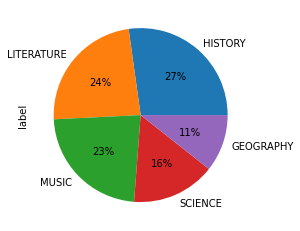

In [5]:
Corpus["label"].value_counts().plot(kind="pie", autopct="%.0f%%")


     Training Set

In [6]:
#generiamo una nuova colonna chiamata text_final in cui andiamo
#a eliminare le stopword e a lemmizzare gli elementi della frase nella colonna question
for index,entry in enumerate(Corpus['question']):
    Final_words = []
    word_Lemmatized = WordNetLemmatizer()
    for word, tag in pos_tag(entry):
        if word not in stopwords.words('english') and word.isalpha():
            word_Final = word_Lemmatized.lemmatize(word,tag_map[tag[0]])
            Final_words.append(word_Final)
    Corpus.loc[index,'text_final'] = str(Final_words)



In [7]:
Corpus.head(5)

,label,question,text_final
0,HISTORY,"[``, this, state, 's, been, ``, '', on, my, mi...","['state', 'mind', 'since', 'enter', 'union', '..."
1,LITERATURE,"[western, novelist, francis, harte, 's, middle...","['western', 'novelist', 'francis', 'harte', 'm..."
2,MUSIC,"[``, this, ``, '', billy, the, kid, '', '', co...","['billy', 'kid', 'composer', 'oscar', 'score',..."
3,MUSIC,"[noted, with, a, dot, on, the, score, ,, it, '...","['note', 'dot', 'score', 'opposite', 'legato',..."
4,SCIENCE,"[if, the, solar, system, 's, 9, planets, were,...","['solar', 'system', 'planet', 'line', 'small',..."


In [8]:
a=Corpus.drop('question', axis=1)
a.head(5)

,label,text_final
0,HISTORY,"['state', 'mind', 'since', 'enter', 'union', '..."
1,LITERATURE,"['western', 'novelist', 'francis', 'harte', 'm..."
2,MUSIC,"['billy', 'kid', 'composer', 'oscar', 'score',..."
3,MUSIC,"['note', 'dot', 'score', 'opposite', 'legato',..."
4,SCIENCE,"['solar', 'system', 'planet', 'line', 'small',..."


Test Set

In [9]:

#stesso preprocessing per il test_set    
devClean = pd.read_csv("test_set.txt", header = None, sep="delimiter", encoding='latin-1', engine = "python")
devClean = devClean[0].str.split('\t', 1, expand=True)
devClean.columns=["label", "question"]
devClean['question'] = devClean['question'].str.replace('\t',' ')

devClean['question'].dropna(inplace=True)

devClean['question'] = [entry.lower() for entry in devClean['question']]

devClean['question']= [word_tokenize(entry) for entry in devClean['question']]

tag_map = defaultdict(lambda : wn.NOUN)
tag_map['J'] = wn.ADJ
tag_map['V'] = wn.VERB
tag_map['R'] = wn.ADV


for index,entry in enumerate(devClean['question']):
    Final_words = []
    word_Lemmatized = WordNetLemmatizer()
    for word, tag in pos_tag(entry):
        if word not in stopwords.words('english') and word.isalpha():
            word_Final = word_Lemmatized.lemmatize(word,tag_map[tag[0]])
            Final_words.append(word_Final)
    devClean.loc[index,'text_final'] = str(Final_words)



## Encoding

Encoding Label

In [10]:
#vado a creare due array sia per il training che per il test set in cui parametrizzo le 
#etichette della colonna label del corpus (esempio: HISTORY=1, LITERATURE=2, MUSIC=3,...)

Encoder = LabelEncoder()
Corpus_label = Encoder.fit_transform(Corpus["label"])
devClean_label = Encoder.fit_transform(devClean["label"])

Corpus_label


array([1, 2, 3, ..., 1, 1, 1])

Encoding testo mediante Tf-Idf

In [11]:
#vettorizzazione delle word all'interno della colonna text_final con l'uso di tfidf
#max_feature=5000 definisce il limite massimo di parole da utilizzare per il tfidf
Tfidf_vect = TfidfVectorizer(max_features=5000)
Tfidf_vect.fit(Corpus['text_final'])
Train_X_Tfidf = Tfidf_vect.transform(Corpus['text_final'])
Test_X_Tfidf = Tfidf_vect.transform(devClean["text_final"])

In [12]:
Test_X_Tfidf

<500x5000 sparse matrix of type '<class 'numpy.float64'>'
	with 3621 stored elements in Compressed Sparse Row format>

# ALGORITMI UTILIZZATI PER LA CLASSIFICAZIONE

# NB

In [13]:
#implementazione modello di predizione Naive Bayes
Naive = naive_bayes.MultinomialNB()
Naive.fit(Train_X_Tfidf,Corpus["label"])
predictions_NB = Naive.predict(Test_X_Tfidf)
print("Naive Bayes Accuracy Score -> ",accuracy_score(devClean["label"], predictions_NB)*100)

Naive Bayes Accuracy Score ->  84.0


In [14]:
print(classification_report(devClean["label"], predictions_NB))

              precision    recall  f1-score   support

   GEOGRAPHY       0.86      0.78      0.82        40
     HISTORY       0.76      0.87      0.81       138
  LITERATURE       0.88      0.86      0.87       124
       MUSIC       0.83      0.84      0.83       110
     SCIENCE       0.95      0.80      0.86        88

    accuracy                           0.84       500
   macro avg       0.86      0.83      0.84       500
weighted avg       0.85      0.84      0.84       500



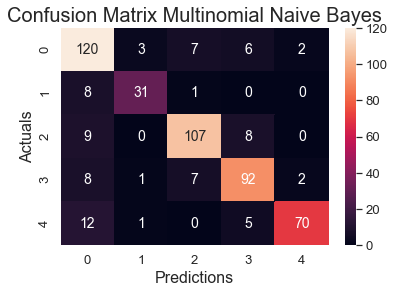

In [15]:
#vado a graficare la confusion matrix per il modello NB

y_actu = devClean["label"]
y_pred = predictions_NB
confusion_matrix(y_actu,y_pred)

array = confusion_matrix(y_actu,y_pred, normalize = None, labels=["HISTORY","GEOGRAPHY","LITERATURE", "MUSIC","SCIENCE"])

df_cm = pd.DataFrame(array, range(5), range(5))


sn.set(font_scale=1.2) 
sn.heatmap(df_cm, annot=True, annot_kws={"size": 14}, fmt = "d") 
plt.xlabel('Predictions', fontsize=16)
plt.ylabel('Actuals', fontsize=16)
plt.title('Confusion Matrix Multinomial Naive Bayes', fontsize=20)
plt.show()

In [16]:
NB=pd.DataFrame(predictions_NB)
NB.to_csv("NB.csv")

# SVM

In [20]:
#implementazione modello di predizione SVM
SVM = svm.SVC(C=1.0, kernel='linear', degree=1, gamma='auto')
SVM.fit(Train_X_Tfidf,Corpus["label"])

predictions_SVM = SVM.predict(Test_X_Tfidf)

print("SVM Accuracy Score -> ",accuracy_score(devClean["label"], predictions_SVM)*100)

SVM Accuracy Score ->  86.4


In [21]:
print(classification_report(devClean["label"], predictions_SVM))

              precision    recall  f1-score   support

   GEOGRAPHY       0.79      0.85      0.82        40
     HISTORY       0.81      0.85      0.83       138
  LITERATURE       0.91      0.86      0.89       124
       MUSIC       0.87      0.86      0.87       110
     SCIENCE       0.92      0.90      0.91        88

    accuracy                           0.86       500
   macro avg       0.86      0.86      0.86       500
weighted avg       0.87      0.86      0.86       500



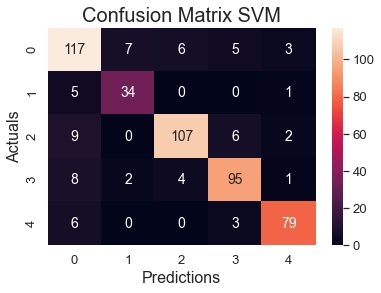

In [22]:
#vado a graficare la confusion matrix per il modello SVM

y_actu = devClean["label"]
y_pred = predictions_SVM
confusion_matrix(y_actu,y_pred)

array = confusion_matrix(y_actu,y_pred, normalize = None, labels=["HISTORY","GEOGRAPHY","LITERATURE", "MUSIC","SCIENCE"])

df_cm = pd.DataFrame(array, range(5), range(5))


sn.set(font_scale=1.2) 
sn.heatmap(df_cm, annot=True, annot_kws={"size": 14}, fmt = "d") 
plt.xlabel('Predictions', fontsize=16)
plt.ylabel('Actuals', fontsize=16)
plt.title('Confusion Matrix SVM', fontsize=20)
plt.show()

In [23]:
SVM=pd.DataFrame(predictions_SVM)
SVM.to_csv("SVM.csv")

# DTC

In [24]:
#implementazione Decision Tree Classifier
from sklearn import tree

DTC = tree.DecisionTreeClassifier()
DTC = DTC.fit(Train_X_Tfidf,Corpus["label"])
prediction_DTC = DTC.predict(Test_X_Tfidf)
print("DTC Accuracy Score -> ", accuracy_score(devClean["label"],prediction_DTC)*100)

DTC Accuracy Score ->  70.8


In [25]:
print(classification_report(devClean["label"], prediction_DTC))

              precision    recall  f1-score   support

   GEOGRAPHY       0.55      0.70      0.62        40
     HISTORY       0.71      0.61      0.65       138
  LITERATURE       0.75      0.78      0.77       124
       MUSIC       0.66      0.74      0.70       110
     SCIENCE       0.81      0.73      0.77        88

    accuracy                           0.71       500
   macro avg       0.70      0.71      0.70       500
weighted avg       0.71      0.71      0.71       500



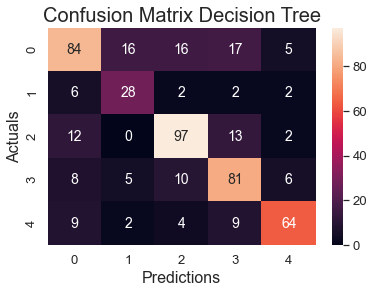

In [26]:
#vado a graficare la confusion matrix per il modello DTC

y_actu = devClean["label"]
y_pred = prediction_DTC
confusion_matrix(y_actu,y_pred)

array = confusion_matrix(y_actu,y_pred, normalize = None, labels=["HISTORY","GEOGRAPHY","LITERATURE", "MUSIC","SCIENCE"])

df_cm = pd.DataFrame(array, range(5), range(5))


sn.set(font_scale=1.2) 
sn.heatmap(df_cm, annot=True, annot_kws={"size": 14}, fmt = "d") 
plt.xlabel('Predictions', fontsize=16)
plt.ylabel('Actuals', fontsize=16)
plt.title('Confusion Matrix Decision Tree', fontsize=20)
plt.show()

In [27]:
DT=pd.DataFrame(prediction_DTC)
DT.to_csv("DT.csv")

# RF

In [28]:
from sklearn.ensemble import RandomForestClassifier

In [29]:
RFC = RandomForestClassifier(n_estimators=30)
RFC = RFC.fit(Train_X_Tfidf,Corpus["label"])
prediction_RFC = RFC.predict(Test_X_Tfidf)
print("RFC Accuracy Score -> ", accuracy_score(devClean["label"],prediction_RFC)*100)

RFC Accuracy Score ->  81.0


In [30]:
print(classification_report(devClean["label"], prediction_RFC))

              precision    recall  f1-score   support

   GEOGRAPHY       0.68      0.80      0.74        40
     HISTORY       0.79      0.78      0.78       138
  LITERATURE       0.87      0.81      0.84       124
       MUSIC       0.79      0.84      0.81       110
     SCIENCE       0.86      0.83      0.84        88

    accuracy                           0.81       500
   macro avg       0.80      0.81      0.80       500
weighted avg       0.81      0.81      0.81       500



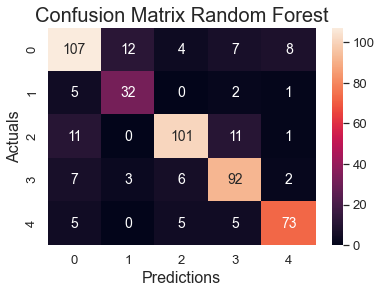

In [31]:
#vado a graficare la confusion matrix per il modello RF

y_actu = devClean["label"]
y_pred = prediction_RFC
confusion_matrix(y_actu,y_pred)

array = confusion_matrix(y_actu,y_pred, normalize = None, labels=["HISTORY","GEOGRAPHY","LITERATURE", "MUSIC","SCIENCE"])

df_cm = pd.DataFrame(array, range(5), range(5))


sn.set(font_scale=1.2) 
sn.heatmap(df_cm, annot=True, annot_kws={"size": 14}, fmt = "d") 
plt.xlabel('Predictions', fontsize=16)
plt.ylabel('Actuals', fontsize=16)
plt.title('Confusion Matrix Random Forest', fontsize=20)
plt.show()

In [32]:
RF=pd.DataFrame(prediction_RFC)
RF.to_csv("RF.csv")

# MLP


In [33]:
#implementazione MLPclassifier
from sklearn.neural_network import MLPClassifier

clf = MLPClassifier(solver='adam', alpha=1e-2,
                     hidden_layer_sizes=(10,6), random_state=1, validation_fraction=0.1, early_stopping=True, activation = 'tanh')
clf.fit(Train_X_Tfidf,Corpus["label"])

prediction_MLP = clf.predict(Test_X_Tfidf)
print("MLP Accuracy Score -> ", accuracy_score(devClean["label"],prediction_MLP)*100)

MLP Accuracy Score ->  85.39999999999999


In [34]:
print(classification_report(devClean["label"], prediction_MLP))

              precision    recall  f1-score   support

   GEOGRAPHY       0.72      0.85      0.78        40
     HISTORY       0.81      0.83      0.82       138
  LITERATURE       0.91      0.89      0.90       124
       MUSIC       0.86      0.88      0.87       110
     SCIENCE       0.91      0.82      0.86        88

    accuracy                           0.85       500
   macro avg       0.84      0.85      0.85       500
weighted avg       0.86      0.85      0.85       500



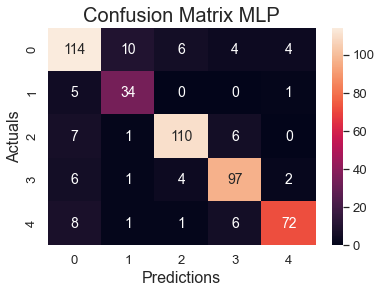

In [35]:
#vado a graficare la confusion matrix per il modello MLP

y_actu = devClean["label"]
y_pred = prediction_MLP
confusion_matrix(y_actu,y_pred)

array = confusion_matrix(y_actu,y_pred, normalize = None, labels=["HISTORY","GEOGRAPHY","LITERATURE", "MUSIC","SCIENCE"])

df_cm = pd.DataFrame(array, range(5), range(5))


sn.set(font_scale=1.2) 
sn.heatmap(df_cm, annot=True, annot_kws={"size": 14}, fmt = "d") 
plt.xlabel('Predictions', fontsize=16)
plt.ylabel('Actuals', fontsize=16)
plt.title('Confusion Matrix MLP', fontsize=20)
plt.show()

In [36]:
MLP=pd.DataFrame(prediction_MLP)
MLP.to_csv("MLP.csv")